# Fashion Product Images Dataset

The growing e-commerce industry presents us with a large dataset waiting to be scraped and researched upon. In addition to professionally shot high resolution product images, we also have multiple label attributes describing the product which was manually entered while cataloging. To add to this, we also have descriptive text that comments on the product characteristics.

In [1]:
from fastai.vision import *
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

import torch
from torch import nn
from torchvision import transforms, utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import re
from tqdm import tqdm

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Run once per session

! cp /gdrive/MyDrive/fashion-dataset.zip /content/ -v
!unzip fashion-dataset.zip
!rm fashion-dataset.zip

In [4]:
IMAGES_PATH = "/content/fashion-dataset/images"
STYLES_PATH = "/content/fashion-dataset/styles"
STYLES_FILE_PATH = "/content/fashion-dataset/styles.csv"
IMAGES_FILE_PATH = "/content/fashion-dataset/images.csv"

In [5]:
styles_df = pd.read_csv(STYLES_FILE_PATH, index_col=False, error_bad_lines=False)
print(styles_df.shape)
styles_df.head()

(44424, 10)


b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [6]:
# Convert image names to integer

images = os.listdir("/content/fashion-dataset/images")
images_list = [re.findall(r"\d+", x)[0] for x in images]
images_list = [int(x) for x in images_list]
len(images_list)

44441

In [7]:
# Filter out df with existing images

styles_df = styles_df[styles_df.id.isin(images_list)]
styles_df.shape

(44419, 10)

In [9]:
# Split data to train and test datasets

train_df, valid_df = torch.utils.data.random_split(styles_df, [30_000, 14_419], generator=torch.Generator().manual_seed(42))

## fastai benchmark

In [10]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
path = Path('/content/fashion-dataset')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content/fashion-dataset')

In [12]:
train_data, valid_data = train_test_split(styles_df)
train_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
9755,28149,Men,Apparel,Innerwear,Innerwear Vests,Grey Melange,Summer,2016.0,Casual,Jockey SPORT Men Grey Melange Innerwear Vest 9924
29097,17930,Women,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Nike Women Casual Black Track Pant
10315,38317,Men,Accessories,Wallets,Wallets,Black,Summer,2012.0,Casual,Puma Men Black Big Cat Wallet
23729,18465,Women,Personal Care,Fragrance,Perfume and Body Mist,White,Spring,2017.0,Casual,Reebok Reefresh Women Perfumes
29956,8662,Men,Accessories,Eyewear,Sunglasses,Green,Winter,2016.0,Casual,Fastrack Men Bikers Green Sunglasses


In [13]:
train_data['label'] = train_data.masterCategory + " " + train_data.subCategory
train_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,label
9755,28149,Men,Apparel,Innerwear,Innerwear Vests,Grey Melange,Summer,2016.0,Casual,Jockey SPORT Men Grey Melange Innerwear Vest 9924,Apparel Innerwear
29097,17930,Women,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Nike Women Casual Black Track Pant,Apparel Bottomwear
10315,38317,Men,Accessories,Wallets,Wallets,Black,Summer,2012.0,Casual,Puma Men Black Big Cat Wallet,Accessories Wallets
23729,18465,Women,Personal Care,Fragrance,Perfume and Body Mist,White,Spring,2017.0,Casual,Reebok Reefresh Women Perfumes,Personal Care Fragrance
29956,8662,Men,Accessories,Eyewear,Sunglasses,Green,Winter,2016.0,Casual,Fastrack Men Bikers Green Sunglasses,Accessories Eyewear


In [14]:
# Take sample of 3000 images

np.random.seed(42)
src = (ImageList.from_df(df=train_data.sample(3000), path='/content/fashion-dataset/images', cols='id', suffix=".jpg")
    .split_by_rand_pct(0.2)
    .label_from_df(label_delim=" ", cols='label'))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [15]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

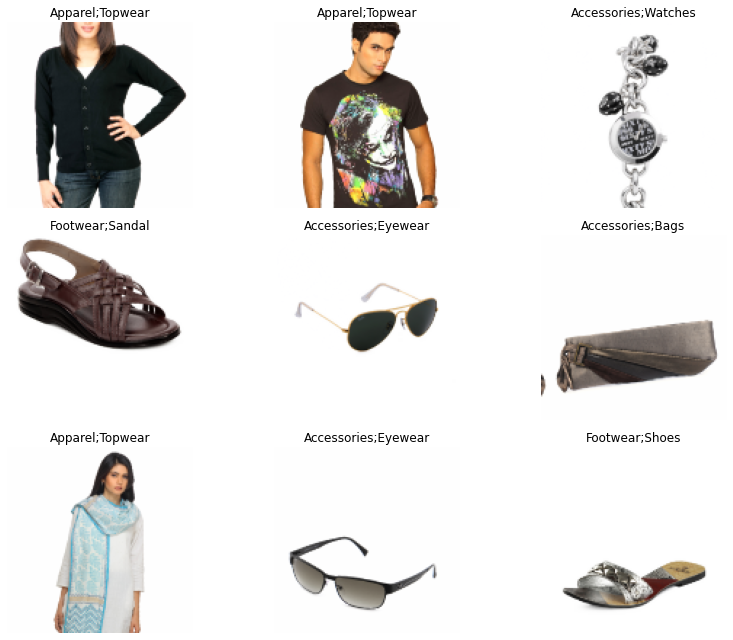

In [16]:
data.show_batch(rows=3, figsize=(12,9))

In [17]:
arch = models.resnet50

In [18]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


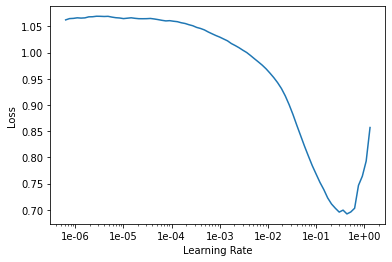

In [ ]:
learn.recorder.plot()

In [19]:
lr = 0.01

In [20]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.593886,0.064236,0.977159,0.861310,03:07
1,0.222685,0.028106,0.989886,0.914862,03:04
2,0.110901,0.026504,0.990909,0.920107,03:05


In [21]:
learn.save('/content/stage-1-rn50')

In [24]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


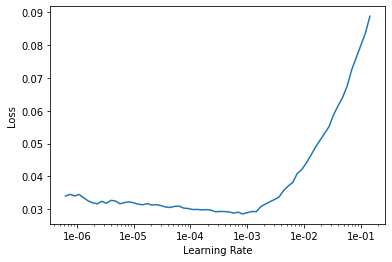

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(3, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.029569,0.022962,0.992614,0.936783,03:04
1,0.023187,0.018930,0.994053,0.955647,03:04
2,0.017435,0.017669,0.994886,0.957659,03:04


In [ ]:
learn.save('/content/stage-2-rn50')

In [29]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [30]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


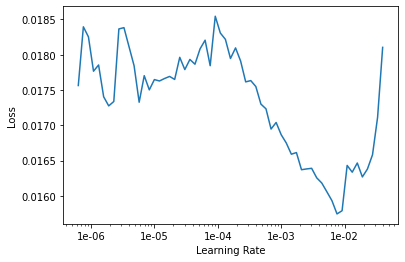

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [31]:
lr=1e-2/2

In [32]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.021078,0.020318,0.991629,0.950126,03:41
1,0.017526,0.017341,0.994280,0.960274,03:41
2,0.013856,0.016107,0.995454,0.963033,03:41


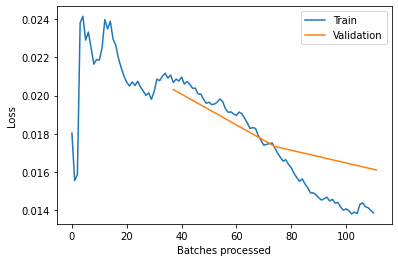

In [33]:
learn.recorder.plot_losses()

In [ ]:
learn.save('/content/stage-2-256-rn50')

In [36]:
learn.export("/content/export.pkl")

### Test dataset

In [37]:
valid_data['label'] = valid_data.masterCategory + " " + valid_data.subCategory

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
test = ImageList.from_df(df=valid_data.sample(1000), path='/content/fashion-dataset/images', cols='id', suffix=".jpg")

In [40]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [41]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [42]:
labelled_preds[:5]

['Apparel Topwear',
 'Apparel Innerwear',
 'Apparel Bottomwear',
 'Apparel Saree',
 'Footwear Shoes']

In [43]:
fnames = [int(re.findall("\d+", f)[0]) for f in learn.data.test_ds.items]

In [44]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [45]:
df.head(10)

,image_name,tags
0,28848,Apparel Topwear
1,51776,Apparel Innerwear
2,24656,Apparel Bottomwear
3,53008,Apparel Saree
4,44415,Footwear Shoes
5,20844,Accessories Mufflers Scarves
6,18394,Apparel Innerwear
7,31112,Apparel Bottomwear
8,59178,Footwear Shoes
9,18954,Accessories Socks


In [46]:
inspect_df = df.merge(valid_data[['id','label']], how='left', left_on='image_name', right_on='id')
inspect_df[inspect_df.tags != inspect_df.label]

,image_name,tags,id,label
2,24656,Apparel Bottomwear,24656,Accessories Socks
5,20844,Accessories Mufflers Scarves,20844,Accessories Mufflers
11,35014,Apparel Topwear,35014,Accessories Stoles
20,51808,Apparel Topwear,51808,Apparel Loungewear and Nightwear
21,55395,Care Lips Personal,55395,Personal Care Eyes
...,...,...,...,...
978,42290,Accessories Apparel Bottomwear,42290,Apparel Bottomwear
982,57057,Apparel Dress Topwear,57057,Apparel Dress
993,41864,Footwear Shoes,41864,Footwear Sandal
996,44546,Footwear Sandal Shoes,44546,Footwear Sandal


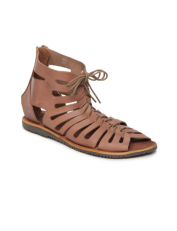

In [51]:
plt.imshow(Image.open(f"/content/fashion-dataset/images/{df.image_name.iloc[993]}.jpg"))
plt.axis('off');

# PyTorch (only master Category)


In [53]:
styles_df = pd.read_csv(STYLES_FILE_PATH, index_col=False, error_bad_lines=False)
styles_df.masterCategory = styles_df.masterCategory.astype('category')
styles_df = styles_df[styles_df.id.isin(images_list)]

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [54]:
mapper = dict(zip(styles_df.masterCategory, styles_df.masterCategory.cat.codes))
mapper

{'Accessories': 0,
 'Apparel': 1,
 'Footwear': 2,
 'Free Items': 3,
 'Home': 4,
 'Personal Care': 5,
 'Sporting Goods': 6}

In [55]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transforms=None):
        self.dataset = dataset
        self.indices = indices
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        id = row.id
        label = row.masterCategory
        path = f"/content/fashion-dataset/images/{id}.jpg"
        image = Image.open(path)
        if self.transforms:
            image = self.transforms(image)
        return image, mapper.get(label)


In [56]:
IMAGE_SIZE = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(1),
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.Normalize(mean=[.8], std=[.5])
])

In [57]:
train_dataset = TrainDataset(styles_df, train_df.indices, transforms=transform)
valid_dataset = TrainDataset(styles_df, valid_df, transforms=transform)

torch.Size([1, 128, 128])
2


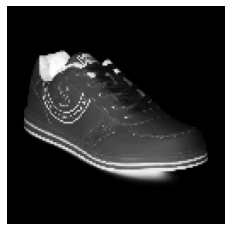

In [58]:
img, label = train_dataset[155]
print(img.shape)
print(label)
plt.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='binary')
plt.axis('off');

In [59]:
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=True, num_workers=4) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [60]:
input_size = IMAGE_SIZE ** 2
hidden_size = [256, 64]
output_size = 7

model = nn.Sequential(
    nn.Linear(input_size, hidden_size[0]),
    nn.ReLU(),
    nn.Linear(hidden_size[0], hidden_size[1]),
    nn.ReLU(),
    nn.Linear(hidden_size[1], output_size),
    nn.LogSoftmax(dim=1)
)
model

Sequential(
  (0): Linear(in_features=16384, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=7, bias=True)
  (5): LogSoftmax(dim=1)
)

In [61]:
criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [62]:
if torch.cuda.is_available():
    model = model.cuda()
    optimizer = optimizer

In [63]:
epochs = 1

for e in range(epochs):
    train_running_loss = 0.0
    valid_running_loss = 0.0

    for images, labels in tqdm(train_dataloader, position=0, leave=True, desc='Training'):
        images = images.view(-1, 128*128)
        labels =labels.long()
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() / BATCH_SIZE

    with torch.no_grad():
        for images, labels in tqdm(valid_dataloader, position=0, leave=True, desc='Validation'):
            images = images.view(-1, 128*128)
            labels =labels.long()
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            output = model(images)
            loss = criterion(output, labels)

            valid_running_loss += loss.item() / BATCH_SIZE

    print('[Epoch: %d, Iteration: %5d] Train Loss: %.5f  |  Valid Loss: %.5f' % (e + 1, i + 1, train_running_loss, valid_running_loss))
    running_loss = 0.0

print('Finished Training')

Training:   0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Validation: 100%|██████████| 226/226 [14:04<00:00,  3.74s/it]


NameError: ignored

In [64]:
print('[Epoch: %d] Train Loss: %.5f  |  Valid Loss: %.5f' % (e + 1, train_running_loss, valid_running_loss))

[Epoch: 1] Train Loss: 1.88422  |  Valid Loss: 0.74220
